In [1]:

from inference_toolbox.model import Model, add_model, delete_model
from inference_toolbox.likelihood import Likelihood
from inference_toolbox.parameter import Parameter
from visualisation_toolbox.domain import Domain
from controllers.sampler import Sampler
from visualisation_toolbox.visualiser import Visualiser
from data_processing.sim_data_processor import SimDataProcessor
from data_processing.raw_data_processor import RawDataProcessor
import numpy as np
import pandas as pd
import os

os.chdir('/PhD_project/')

/build/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[ 0.85911676 -0.14088324  0.47140452]
 [-0.14088324  0.85911676  0.47140452]
 [-0.47140452 -0.47140452  0.71823351]]


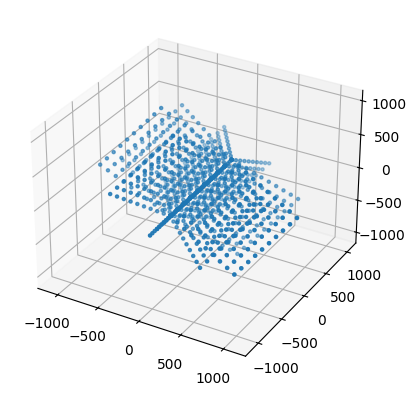

array([[-235.7022604 , -235.7022604 , -358.1167564 ],
       [-235.7022604 , -235.7022604 , -358.1167564 ],
       [-235.7022604 , -235.7022604 , -358.1167564 ],
       ...,
       [ 523.62923012, -634.82670056,  742.5010473 ],
       [ 984.38188102, -424.45017178,  302.0129279 ],
       [1094.81901679,   94.81901679, -111.28776439]])

In [4]:
sim_domain = Domain('cylinder').add_domain_param('r',1000).add_domain_param('source', [0,0,1]).add_domain_param('h',1000).add_domain_param('resolution',10).add_domain_param('orientation',[1,1,1])

points = sim_domain.create_domain()
points = sim_domain.create_domain_slice(points, 'z', 0)
sim_domain.visualise_points(points)
points
